In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hannakasaei","key":"77803461fa9cd5f2f0c8d349a294d5e7"}'}

In [3]:
import os
import zipfile

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 995MB/s]


In [5]:
!unzip -q fer2013.zip -d fer2013_data

# Transfer Learning with ResNet18
We define a custom model EmotionResNet using a pre-trained ResNet18 as the backbone.
Modifications:

The first convolutional layer is adjusted to accept grayscale images.

The final fully connected layer is replaced to output predictions for 7 emotion classes.



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import numpy as np
import os
from torchvision.models import resnet18, ResNet18_Weights

class EmotionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionResNet, self).__init__()
        weights = ResNet18_Weights.DEFAULT  # مطابق با هش صحیح
        self.base_model = resnet18(weights=weights)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # برای grayscale
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Parameters
Define key hyperparameters and dataset paths:

batch_size: Size of data batches during training.

epochs: Number of training iterations.

lr: Learning rate for the optimizer.

train_dir, val_dir: Paths to the training and validation image folders.

In [7]:
# 🔧 Parameters

batch_size = 64
epochs = 20
lr = 0.0001
train_dir = "/content/fer2013_data/train"
val_dir = "/content/fer2013_data/test"

# Transforms
Image preprocessing steps:

Training transform includes:

Grayscale conversion

Resize to 224x224

Random horizontal flip

Random rotation

Normalization (mean = 0.485, std = 0.229)

Validation transform is similar but without augmentations for consistent evaluation.

In [8]:
# 📦 Transforms

transform_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

transform_val = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

# Data Loaders
Use ImageFolder to load labeled images from directories and apply the transforms.
DataLoader wraps the datasets to:

Enable batch processing

Shuffle training data for better generalization


In [9]:
# 📁 Data Loaders

train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data = datasets.ImageFolder(val_dir, transform=transform_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
class_names = train_data.classes

# Model Setup
Initialize and prepare the model:

Move model to GPU (cuda) if available

Use CrossEntropyLoss for multi-class classification

Use Adam optimizer

Apply a learning rate scheduler (StepLR) to reduce the learning rate every 7 epochs

In [32]:
from collections import Counter
import os
from torchvision import datasets

# بارگذاری dataset بدون transform برای شمردن تعداد نمونه‌ها
raw_dataset = datasets.ImageFolder(train_dir)
labels = [label for _, label in raw_dataset.imgs]

# شمارش تعداد نمونه در هر کلاس
label_counts = Counter(labels)
num_classes = len(raw_dataset.classes)

# تبدیل به Tensor و محاسبه وزن معکوس
class_counts = torch.tensor([label_counts[i] for i in range(num_classes)], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()


In [33]:
# 🧠 Model Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionResNet(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

In [42]:
for idx, class_name in enumerate(raw_dataset.classes):
    print(f"{class_name}: {label_counts[idx]} samples")

angry: 3995 samples
disgust: 436 samples
fear: 4097 samples
happy: 7215 samples
neutral: 4965 samples
sad: 4830 samples
surprise: 3171 samples


In [43]:
for i, (cls, weight) in enumerate(zip(raw_dataset.classes, class_weights)):
    print(f"کلاس '{cls}' (index {i}): وزن = {weight:.4f}")

کلاس 'angry' (index 0): وزن = 0.0686
کلاس 'disgust' (index 1): وزن = 0.6283
کلاس 'fear' (index 2): وزن = 0.0669
کلاس 'happy' (index 3): وزن = 0.0380
کلاس 'neutral' (index 4): وزن = 0.0552
کلاس 'sad' (index 5): وزن = 0.0567
کلاس 'surprise' (index 6): وزن = 0.0864


In [44]:
print(dict(zip(raw_dataset.classes, class_counts)))

{'angry': tensor(3995.), 'disgust': tensor(436.), 'fear': tensor(4097.), 'happy': tensor(7215.), 'neutral': tensor(4965.), 'sad': tensor(4830.), 'surprise': tensor(3171.)}


# Training Loop
Train the model for the defined number of epochs:

Enable training mode with model.train()

Forward pass, compute loss, backpropagate, and update weights

Track total loss and accuracy

Print epoch-wise metrics

Adjust learning rate using the scheduler



In [34]:
for epoch in range(epochs):
    # 🔁 Phase 1: Training
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = output.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100. * correct / total
    train_losses.append(total_loss)
    train_accuracies.append(train_accuracy)

    # 📉 Phase 2: Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            loss = criterion(output, labels)

            val_loss += loss.item()
            preds = output.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f}, Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.2f}%")

Epoch 1 | Train Loss: 790.0306, Acc: 42.89% | Val Loss: 197.2386, Acc: 51.21%
Epoch 2 | Train Loss: 686.7715, Acc: 57.12% | Val Loss: 189.0421, Acc: 59.56%
Epoch 3 | Train Loss: 643.8691, Acc: 62.93% | Val Loss: 184.1201, Acc: 59.89%
Epoch 4 | Train Loss: 610.4543, Acc: 67.33% | Val Loss: 182.7395, Acc: 62.80%
Epoch 5 | Train Loss: 581.3230, Acc: 71.27% | Val Loss: 182.8844, Acc: 63.35%
Epoch 6 | Train Loss: 549.6614, Acc: 75.00% | Val Loss: 181.8332, Acc: 65.31%
Epoch 7 | Train Loss: 526.1457, Acc: 78.37% | Val Loss: 183.9435, Acc: 64.24%
Epoch 8 | Train Loss: 472.5014, Acc: 85.80% | Val Loss: 178.9610, Acc: 67.30%
Epoch 9 | Train Loss: 455.9421, Acc: 88.09% | Val Loss: 179.6386, Acc: 67.30%
Epoch 10 | Train Loss: 446.8463, Acc: 89.11% | Val Loss: 180.4374, Acc: 67.26%
Epoch 11 | Train Loss: 438.8268, Acc: 90.18% | Val Loss: 181.0095, Acc: 67.62%
Epoch 12 | Train Loss: 433.7487, Acc: 90.76% | Val Loss: 181.6010, Acc: 67.04%
Epoch 13 | Train Loss: 426.0317, Acc: 91.51% | Val Loss: 182.

# Save Model

In [35]:
# 💾 Save Model

torch.save(model.state_dict(), "emotion_model_resnet18.pth")
print("Model saved as emotion_model_resnet18.pth")

Model saved as emotion_model_resnet18.pth


# Training Curves
Plot and visualize:

Training loss over epochs

Training accuracy over epochs

These curves help monitor model learning and detect overfitting or underfitting.

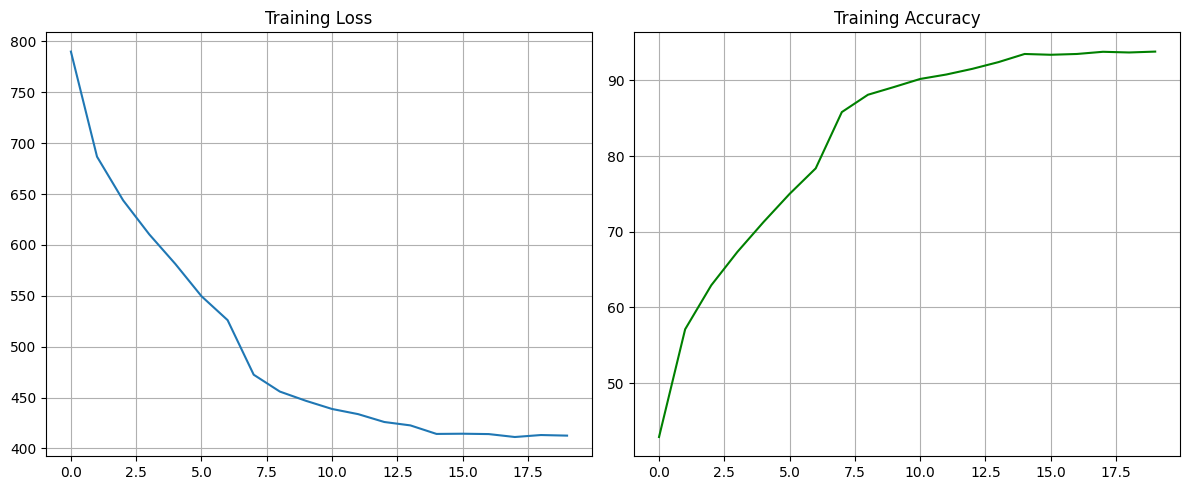

In [36]:
# 📊 Training Curves

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.title('Training Accuracy')
plt.grid(True)
plt.tight_layout()
plt.savefig("training_curves_resnet.png")
plt.show()

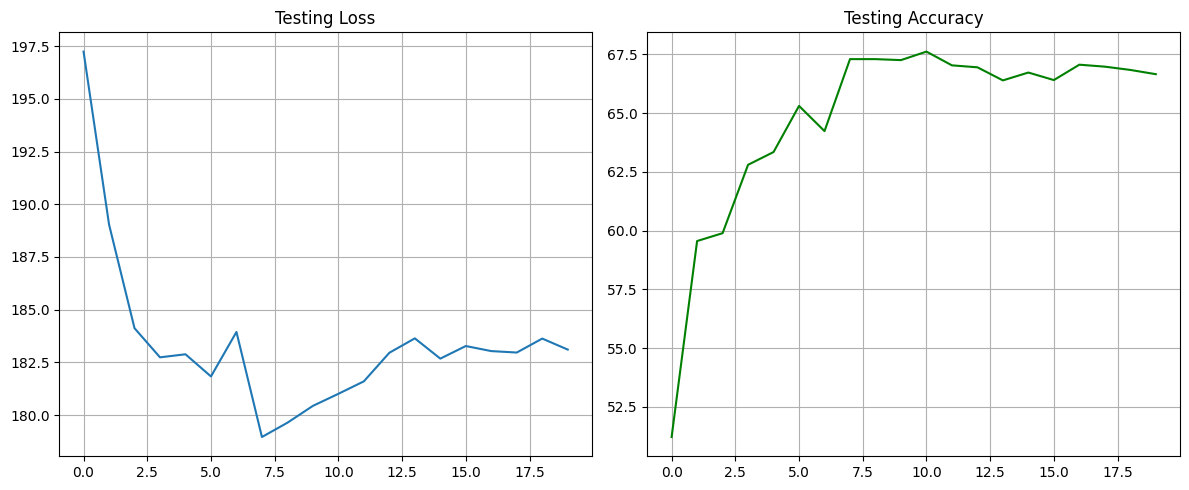

In [37]:
# 📊 Training Curves for test dataset

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Test Loss')
plt.title('Testing Loss')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Test Accuracy', color='green')
plt.title('Testing Accuracy')
plt.grid(True)
plt.tight_layout()
plt.savefig("testing_curves_resnet.png")
plt.show()

# Evaluation
Evaluate the model performance on validation data:

Disable gradient computation with torch.no_grad()

Predict classes for validation set

Show a classification report (precision, recall, F1-score)

Display a confusion matrix to visualize prediction errors per class


Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.60      0.60       958
     disgust       0.17      0.79      0.28       111
        fear       0.59      0.51      0.54      1024
       happy       0.88      0.85      0.87      1774
     neutral       0.66      0.62      0.64      1233
         sad       0.59      0.51      0.54      1247
    surprise       0.78      0.84      0.81       831

    accuracy                           0.67      7178
   macro avg       0.61      0.67      0.61      7178
weighted avg       0.69      0.67      0.67      7178



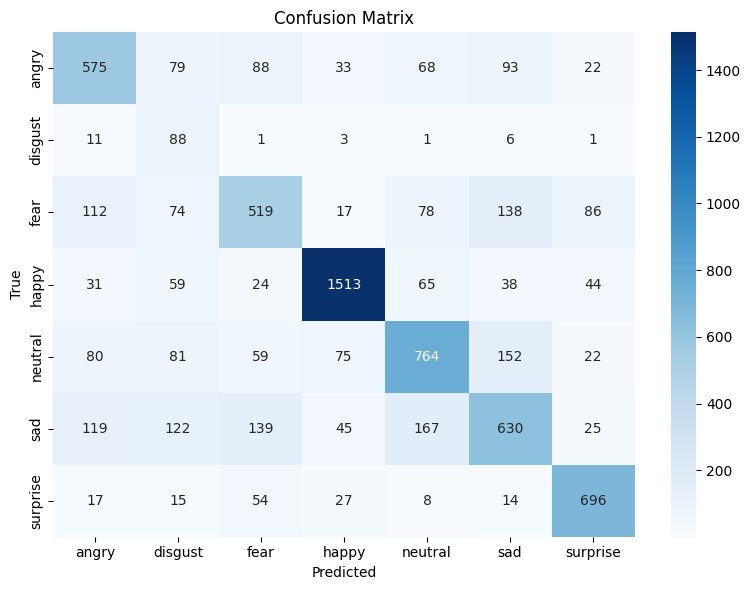

In [38]:
# 📌 Evaluation

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        output = model(imgs)
        preds = output.argmax(dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix_resnet.png")
plt.show()

In [45]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=raw_dataset.classes))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60       958
     disgust       0.17      0.79      0.28       111
        fear       0.59      0.51      0.54      1024
       happy       0.88      0.85      0.87      1774
     neutral       0.66      0.62      0.64      1233
         sad       0.59      0.51      0.54      1247
    surprise       0.78      0.84      0.81       831

    accuracy                           0.67      7178
   macro avg       0.61      0.67      0.61      7178
weighted avg       0.69      0.67      0.67      7178



# Predict Single Image
Use a trained model to predict emotion from a single grayscale face image:

Apply the same preprocessing steps

Perform inference with the model

Output the predicted class label using argmax



In [49]:
# 🔍 Predict Single Image

img = Image.open(r"/content/fer2013_data/test/sad/PrivateTest_62176553.jpg")
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])
img_tensor = transform(img).unsqueeze(0).to(device)
model.eval()

with torch.no_grad():
    output = model(img_tensor)
    pred = torch.argmax(output, 1)
    print(f"Predicted Emotion: {class_names[pred.item()]}")

Predicted Emotion: sad
